# Multiperiod Binomial Model

We are given a **derivative security** (either by formula or by explicit values) that takes on different values based on different realizations of a certain stock or asset. 

Our goal is to sell an option and then invest the profit into the **money market** (just gets interest `r`) or the **stock** (changes based on "coin flip" chance), such that our profits match the outcomes of the derivative security exactly. Determining that sell price will guarantee that there is no arbitrage in the market. 

Because this a multi-period situation, we can make a decision at every time step after seeing how the market moved. We can solve this exactly using dynamic programming / recursion.

## "Defintions":
These definitions may not be exact, but are sufficient for this notebook

1. **Option**: a contract which gives the owner the right to sell (**put**) / buy(**call**) or a stock a certain price
2. **Short**: (borrowing stock) and then selling it. One hopes that the price of the stock goes down, so that you could buy it back for cheaper and return the original stock to the shareholder, while you make profit. 
3. **Long**: (borrowing money) and then buying stock with it. One hopes that the price of the stock goes up, so that you could sell the stock later for more and return the original money, while you make profit. 

# The Setup

We set up the example using a stock `s` that evolves over `N` periods. We also have access to a money market with interest rate `r`. For this problem, we assume that `u` = `1/d`, so that the growth and decay rates cancel each other out in each time period. This crucial simplification simplifies state tabulation since it shrinks the total number of stock price possibilties to `2N+1` options. Thus, we can view state as all possible enumerations of stock price `s` and not realizations of the world (sequence of HTHTH...).

In [1]:
N = 3  # number of periods
r = 0.25  # interest rate for money market
s0 = 4  # initial value of the stock
u = 2  # rate of growth of stock on a "head"
d = 1 / 2  # rate of decrease of stock on a "tail"

assert d < 1 + r < u # no arbertrage condition

Next we define the derivative security. A few examples are listed and defined below.

note: analyzing a lookback_put requires enumerating all realizations of the world and not stock prices since the stock-price paths are relevant for the final calculations. Although effficient approaches exist, I skip it in this analysis. 

In [2]:
def european_put(strike_price, s_n):
    """
    s_n: the price of the stock at expiration

    A contract which gives the RIGHT to the holder to SELL a stock 
    at price strike_price when the time expires.

    returns the payout to the owner of the contract.  
    """
    return max(strike_price - s_n, 0)

def european_call(strike_price, s_n):
    """
    s_n: the price of the stock at expiration

    A contract which gives the RIGHT to the holder to BUY a stock
    at price strike_price when the time expires. 

    returns the payout to the owner of the contract.  
    """
    return max(s_n - strike_price, 0)

def lookback_put(s: list):
    """
    s: ordered list of n stock valuations including the final value at expiration

    A contract which gives the RIGHT to the holder to SELL a stock 
    at the highest valuation of the stock during its lifetime

    returns the payout to the owner of the contract.  
    """
    return max(s) - s[-1]


We use the european put with a strike price of 5

In [3]:
def ds(s):
    return european_put(5, s) 

# Recursive Solution

First we define the risk-neutral probabilties `p_hat` and `q_hat`

In [4]:
p_hat = (1 + r - d) / (u - d)
q_hat = (u - 1 - r) / (u - d)
assert p_hat + q_hat == 1

Next we follow the recursive formulas presented in the book. Note that a DP/backwards-recursion approach or a memoization approach could be used to speed up the recursion. 

In [5]:
def get_portfolio(s0, N, r, u, d):
    """
    Returns a tuple:
        - the value of the derivative security  
        - how much stock you should hold if you wanted to hedge the ds through money market/investments.   
    """

    def recurse_value(s, t):
        """
        Recursively calculate the value of the portfolio when the stock is at 
        value s at time t. 
        """
        if (t == N):
            return ds(s)

        return 1 / (1 + r) * (p_hat * recurse_value(s * u, t+1) + q_hat * recurse_value(s * d, t+1))
    
    v0 = recurse_value(s0, 0)
    delta0 = (recurse_value(s0 * u, 1) - recurse_value(s0 * d, 1)) / (u * s0 - d * s0)
    return v0, delta0

Calling the function gives us:
1. The value the ds should be sold at
2. How much stock you should HOLD in order to hedge your bet. If you begin with 0 of that stock, a positive value indiciates that you should buy that stock and a negative value indicates that you should short (i.e. borrow those number of shares and sell them -> u owe stock) 

In [6]:
sell_price, stock_hold = get_portfolio(s0, N, r, u, d)
verb = "buying" if stock_hold > 0 else "shorting"
print(f"You should sell the derivative security at ${sell_price:.3f}, and hedge by {verb} {abs(stock_hold):.3f} amount of the stock")

You should sell the derivative security at $0.864, and hedge by shorting 0.200 amount of the stock


# Experimentation 

In [31]:
import matplotlib.pyplot as plt
import numpy as np

## Question 1: What happens as N changes?

As the number of periods increases, extreme events (e.g. all H or all T) that lead to large deviations from the mean become more unlikely. Thus, we expect the final stock price to not move too far. This would mean that the derivative security should be lower valued since it's not so likely for it to have a high payout. Furthermore, as the price decreases, the amount of stock you should short decreases as well because a smaller counter is needed. 

Text(0, 0.5, 'Sell Price / Stock Action')

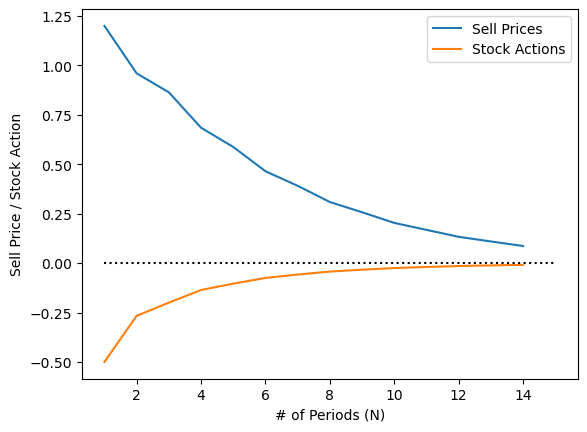

In [29]:
ns = range(1, 15)
prices, stocks = zip(*[get_portfolio(s0, n, r, u, d) for n in ns])

plt.plot(ns, prices, label = 'Sell Prices')
plt.plot(ns, stocks, label = 'Stock Actions')
plt.hlines(0, 1, 15, color = 'black', linestyles='dotted')
plt.legend()
plt.xlabel("# of Periods (N)")
plt.ylabel("Sell Price / Stock Action")

## Question 2: What happens as r changes?

As the interest rate (`r`) increases, the value of investing money in the money market decreases. This increases `p_hat` and decreases `q_hat`, shifting more weight to outcomes with more heads. 

Text(0, 0.5, 'Sell Price / Stock Action')

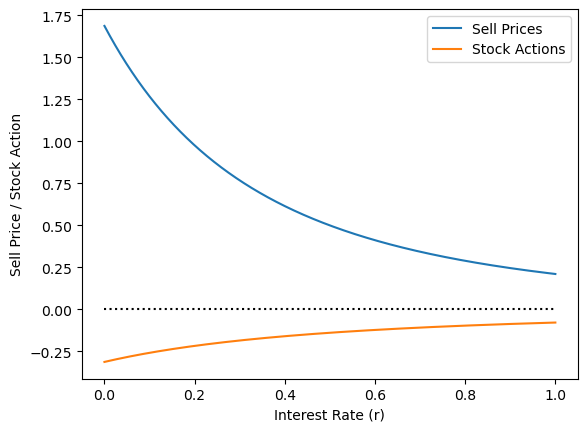

In [38]:
rs = np.linspace(0, 1, 1000)
N = 3
prices, stocks = zip(*[get_portfolio(s0, N, r, u, d) for r in rs])

plt.plot(rs, prices, label = 'Sell Prices')
plt.plot(rs, stocks, label = 'Stock Actions')
plt.hlines(0, min(rs), max(rs), color = 'black', linestyles='dotted')
plt.legend()
plt.xlabel("Interest Rate (r)")
plt.ylabel("Sell Price / Stock Action")